# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.transform import resize
from skimage.io import imread
#from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('data/train.csv').readlines())
val_doc = np.random.permutation(open('data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [84]:
def generator(source_path, folder_list, batch_size):
    #print('source_path: ', source_path)
    
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,14,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           # print("batch labels: ", batch_labels)
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(100,100)).astype(np.float32)
                 
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if len(t)% batch_size !=0:
            batch_data = np.zeros((batch_size,14,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                    
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        image = resize(image,(100,100)).astype(np.float32)

                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'data/train'
val_path = 'data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model 1 - Conv3D
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, ConvLSTM2D, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here


model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(14,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 14, 100, 100, 32)  2624      
                                                                 
 activation_3 (Activation)   (None, 14, 100, 100, 32)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 14, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 7, 50, 50, 64)    

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [8]:
optimizer = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/Users/dhruvchopra/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,
  verbose = 1, mode = "auto", epsilon = 1e-04, cooldown = 0,min_lr = 0)
callbacks_list = [checkpoint, LR]

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
model.fit_generator(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

<ipython-input-12-bd77c9c60c14>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.0272 - categorical_accuracy: 0.2872 
Epoch 1: saving model to model_init_2022-09-1321_06_47.833538/model-00001-2.02716-0.28720-1.61797-0.22656.h5
21/21 [==============================] - 463s 22s/step - loss: 2.0272 - categorical_accuracy: 0.2872 - val_loss: 1.6180 - val_categorical_accuracy: 0.2266 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5683 - categorical_accuracy: 0.4003 
Epoch 2: saving model to model_init_2022-09-1321_06_47.833538/model-00002-1.56828-0.40030-1.76219-0.24219.h5
21/21 [==============================] - 477s 23s/step - loss: 1.5683 - categorical_accuracy: 0.4003 - val_loss: 1.7622 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.3865 - categorical_accuracy: 0.4449 
Epoch 3: saving model to model_init_2022-09-1321_06_47.833538/model-00003-1.38654-0.44494-2.07323-0.17188.h5
21/21 [=========

In [13]:
import pandas as pd

In [14]:
model.name

'sequential_1'

In [17]:
model.count_params()

2454405

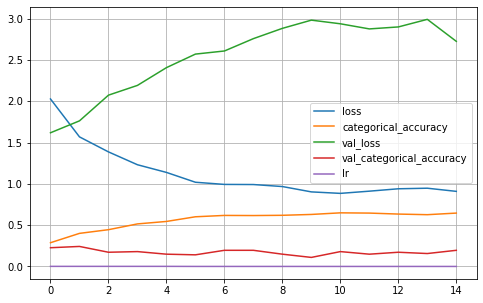

In [18]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.grid('True')
plt.show()

# CNN + LSTM - Final Model

## Generator

In [85]:
def generator(source_path, folder_list, batch_size):
    #print('source_path: ', source_path)
    
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,14,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           # print("batch labels: ", batch_labels)
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(100,100)).astype(np.float32)
                 
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if len(t)% batch_size !=0:
            batch_data = np.zeros((batch_size,14,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                    
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        image = resize(image,(100,100)).astype(np.float32)

                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [86]:
#write your model here
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional

In [101]:
#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(14,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [102]:
optimizer = optimizers.SGD(lr=0.01) #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 14, 100, 100, 32)  2624      
                                                                 
 activation_33 (Activation)  (None, 14, 100, 100, 32)  0         
                                                                 
 batch_normalization_64 (Bat  (None, 14, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 50, 50, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_34 (Conv3D)          (None, 7, 50, 50, 64)     16448     
                                                                 
 activation_34 (Activation)  (None, 7, 50, 50, 64)   

In [103]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [104]:
model_name = 'time_distributed_model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [105]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [106]:
model.fit_generator(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

<ipython-input-106-d4ef7ee1576b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.9462 - categorical_accuracy: 0.3006 
Epoch 1: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00001-1.94617-0.30060-1.58034-0.17188.h5
21/21 [==============================] - 379s 18s/step - loss: 1.9462 - categorical_accuracy: 0.3006 - val_loss: 1.5803 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.7231 - categorical_accuracy: 0.3199 
Epoch 2: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00002-1.72307-0.31994-1.65656-0.16406.h5
21/21 [==============================] - 391s 19s/step - loss: 1.7231 - categorical_accuracy: 0.3199 - val_loss: 1.6566 - val_categorical_accuracy: 0.1641 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.4865 - categorical_accuracy: 0.4062 
Epoch 3: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00003-1.48649-0.40625

Epoch 22/25
21/21 [==============================] - ETA: 0s - loss: 0.3036 - categorical_accuracy: 0.9003 
Epoch 22: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00022-0.30361-0.90030-1.23084-0.57031.h5
21/21 [==============================] - 374s 18s/step - loss: 0.3036 - categorical_accuracy: 0.9003 - val_loss: 1.2308 - val_categorical_accuracy: 0.5703 - lr: 0.0100
Epoch 23/25
21/21 [==============================] - ETA: 0s - loss: 0.2653 - categorical_accuracy: 0.9241 
Epoch 23: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00023-0.26526-0.92411-1.06010-0.63281.h5
21/21 [==============================] - 375s 18s/step - loss: 0.2653 - categorical_accuracy: 0.9241 - val_loss: 1.0601 - val_categorical_accuracy: 0.6328 - lr: 0.0100
Epoch 24/25
21/21 [==============================] - ETA: 0s - loss: 0.2541 - categorical_accuracy: 0.9301 
Epoch 24: saving model to time_distributed_model_2022-09-1321_06_47.833538/model-00024-0.25413-0

In [107]:
model.name

'sequential_16'

In [108]:
model.count_params()

9597701

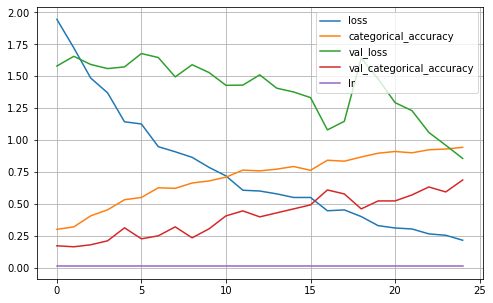

In [109]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.grid('True')
plt.show()